## 9. Neural Network class implemented in NumPy
The following code contains a neural network class implemented in numpy that can be applied to both classification and regression problems. Mini batch gradient descent with momentum is used to optimise the model. 
Below that is a demonstration of the class when applied to two simple generated datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NN():
    """Neural network class that can be applied to both classification and regression problems - 
    optimises using mini-batch gradient descent with momentum"""
    
    def __init__(self, layers, activations, loss_func):
        """accepts list of nodes per layer including input and output dimentions, list of activation functions for 
        each layer - can input 'regression' for final layer if activation function is not needed,
        and accepts a loss function"""
        
        self.layers = layers
        self.L = len(activations)
        self.activations = activations
        # 'd_' functions are for the backward pass
        self.activs = {
            'relu': self.relu,
            'd_relu': self.d_relu,
            'sigmoid': self.sigmoid,
            'd_sigmoid': self.d_sigmoid,
            'regression': self.regression,
            'd_regression': self.d_regression,
        }
        self.loss_func = loss_func
        self.loss_funcs = {
            'binary_crossent': self.binary_crossent,
            'd_binary_crossent': self.d_binary_crossent,
            'squared_loss': self.squared_loss,
            'd_squared_loss': self.d_squared_loss,
        }
        self.params = {}
        self.loss = []
        self.training_acc = []
        self.epochs = 0
        
    def binary_crossent(self, h, y):
        
        n = len(y)
        loss = -(1 / n) * ((y.T @ np.log(h + 1e-5) + (1 - y).T @ np.log(1 - h + 1e-5)))
        
        return np.squeeze(loss)
    
    def d_binary_crossent(self, h, y):
        
        return (-y / (h + 1e-5)) + ( (1 - y) / (1 - h + 1e-5) )
    
    def squared_loss(self, h, y):
        
        n = len(y)
        return (1 / n) * ((h - y).T @ (h - y))
    
    def d_squared_loss(self, h, y):
        
        return (h - y)
    
    def sigmoid(self, z):

        return 1 / (1 + np.exp(-z))

    def d_sigmoid(self, z):
        
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def relu(self, z):

        return np.maximum(0, z)
    
    def d_relu(self, z):
        
        return np.where(z <= 0, 0, 1)
    
    #The next two methods are to allow the class to be used for regression without changing the code
    def regression(self, z):
        
        return z
    
    def d_regression(self, z):
        
        return 1

    def forward_pass(self, data):
        """calculates predictions"""
        
        zs = []
        phis = []
        phis.append(data)
        for i in range(self.L):
            
            w = self.params['w' + str(i)]
            b = self.params['b' + str(i)]

            z = phis[i] @ w + b
            phi = self.activs[self.activations[i]](z)
            
            zs.append(z)
            phis.append(phi)
            
        #phis[-1] are the predictions
        return phis[-1], phis[:-1], zs
    
    def backward_pass(self, h, y, phis, zs):
        """calculates gradients"""
        
        n = len(y)
        dl = (self.loss_funcs['d_' + self.loss_func](h, y) * 
              self.activs['d_' + self.activations[-1]](zs[-1]))
        
        grads = {}
        for i in range(self.L)[::-1]:

            grads['dw' + str(i)] = (dl.T @ phis[i]).T / n
            
            grads['db' + str(i)] = sum(dl) / n
            
            if i == 0:
                break
                
            dl = (self.activs['d_' + self.activations[i-1]](zs[i-1]) * 
                  (dl @ self.params['w' + str(i)].T))
        
        return grads
    
    def optimise(self, grads, alpha, batch_weight, beta, velos):
        """updates parameters according to calculated gradients"""
        
        for i in range(self.L):
            
            if beta != None:
                velos['Gw' + str(i)] = beta * velos['Gw' + str(i)] + alpha * grads['dw' + str(i)]
                velos['Gb' + str(i)] = beta * velos['Gb' + str(i)] + alpha * grads['db' + str(i)]
                
                self.params['w' + str(i)] += - velos['Gw' + str(i)] * batch_weight
                self.params['b' + str(i)] += - velos['Gb' + str(i)] * batch_weight
                
            else:
                self.params['w' + str(i)] += - alpha * grads['dw' + str(i)] * batch_weight
                self.params['b' + str(i)] += - alpha * grads['db' + str(i)] * batch_weight

    def init_velos(self):
        """Initiates velocities for momentum"""
        
        velos = {}
        for i in range(self.L):
            
            velos['Gw' + str(i)] = 0
            velos['Gb' + str(i)] = 0
            
        return velos
    
    def init_params(self, seed):
        """Initiates parameters randomly"""

        np.random.seed(seed)

        for i in range(self.L):

            self.params['w' + str(i)] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.1
            self.params['b' + str(i)] = np.random.randn(self.layers[i+1]) * 0.1            
  
    def mini_batch(self, x, y, batchsize):
        """splits data randomly into given batch sizes"""
        
        n = len(y)
        m = n // batchsize
        
        idx = np.arange(n)
        np.random.shuffle(idx)
        
        x_batches = np.split(x[idx][:m*batchsize], m)
        y_batches = np.split(y[idx][:m*batchsize], m)
        
        #if batchsize doesn't divide evenly into data and remainder is 1 then that sample is not included.
        if n - m*batchsize > 1:
            x_batches.append(x[idx][-(n - m*batchsize):])
            y_batches.append(y[idx][-(n - m*batchsize):])
        
        return x_batches, y_batches
    
    def train(self, data, labels, epochs=1000, batchsize=64, alpha=0.01, momentum=0.9, eps=0.01, seed=0):
        """Accepts num_samples by num_dimentions array of data and num_samples by 1 array of lables/targets,
        labels {0, 1}"""
        
        #can set momentum to None to optimise wihtout it
        velos = self.init_velos() if momentum != None else None
        
        self.init_params(seed)
        self.loss = []
        self.training_acc = []
        self.epochs = 0
        for _ in range(epochs):
            
            #gets new batches for each epoch
            x_batches, y_batches = self.mini_batch(data, labels, batchsize)
            
            batch_loss = 0
            batch_acc = 0
            i = 0
            for x, y in zip(x_batches, y_batches):
                
                #forward
                h, phis, zs = self.forward_pass(x)

                batch_loss += self.loss_funcs[self.loss_func](h, y)
                if self.activations[-1] == 'sigmoid':
                    batch_acc += sum(self.get_class(h) == y) / len(y)
                
                #backward
                grads = self.backward_pass(h, y, phis, zs)
                
                #If batchsize doesn't divide evenly into data, scales step size for final smaller batch
                batch_weight = len(y) / batchsize
                #optimise
                self.optimise(grads, alpha, batch_weight, momentum, velos)
                
                i += 1
            
            self.loss.append(batch_loss / i)
            self.training_acc.append(batch_acc / i)
            self.epochs += 1
            
            if self.loss[-1] <= eps:
                break
    
    def get_class(self, h):
        
        return np.where(h + 1e-5 <= 0.5, 0, 1)
    
    def predict(self, data):
        
        h, _, _ = self.forward_pass(data)
        
        if self.activations[-1] == 'sigmoid':
            return self.get_class(h)
        else:
            return h
        
        

In [3]:
def plot(z, epochs, training_acc, loss):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].plot(range(epochs), loss, 'r', label='Loss')
    ax[0].legend(loc='center left')
    ax2 = ax[0].twinx()
    ax2.plot(range(epochs), training_acc, 'g', label='Training\naccuracy')
    ax2.legend(loc='center right')

    #xx, yy = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
    #mesh = np.vstack((np.ravel(xx), np.ravel(yy))).T
    #z = model.predict(mesh).reshape(xx.shape)
    data0 = data[:, :-1][data[:, -1] == 0]
    data1 = data[:, :-1][data[:, -1] == 1]

    ax[1].contourf(xx, yy, z, [0, 0.5, 1], colors=['b', 'r'], alpha=0.2)
    ax[1].scatter(data1[:, 0], data1[:, 1], color='r', s=10, label='1')
    ax[1].scatter(data0[:, 0], data0[:, 1], color='b', s=10, label='0')
    ax[1].legend()
    plt.show()
    
    print('Training accuracy = {0:.2f}%, \nEpochs = {1}'.format(training_acc[-1][0]*100, epochs))

### Dataset 1
Generating some data to classify - the benefits of using mini batch and momentum are also demonstrated with this dataset

In [4]:
from spiral import spiral

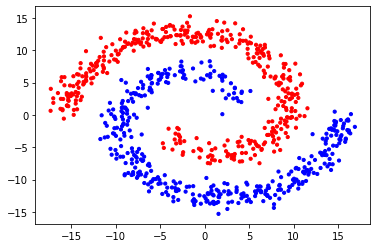

In [5]:
data = spiral(random_seed=0)
plt.scatter(data[:, 0], data[:, 1], s=10, c=data[:, 2], cmap=plt.cm.bwr)
plt.show()

In [6]:
layers = [2, 8, 16, 16, 8, 1]
activations = ['relu', 'relu', 'relu', 'relu', 'sigmoid']
loss_func = 'binary_crossent'

#### First implementing the model with the full batch and without momentum

In [7]:
model = NN(layers, activations, loss_func)
%timeit model.train(data[:, :-1], data[:, -1][:, None], epochs=10000, alpha=0.02, 
                    batchsize=len(data[:, -1]), momentum=None)

46.8 s ± 772 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Converges in around 45s and after 7000 epochs

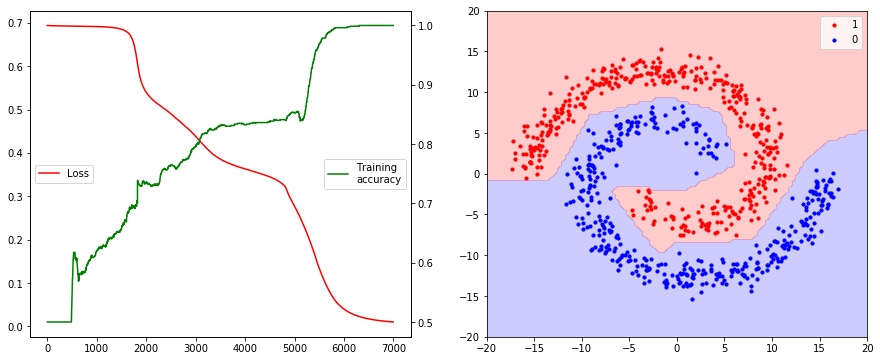

Training accuracy = 100.00%, 
Epochs = 6998


In [8]:
xx, yy = np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100))
mesh = np.vstack((np.ravel(xx), np.ravel(yy))).T
z = model.predict(mesh).reshape(xx.shape)
plot(z, model.epochs, model.training_acc, model.loss)

#### Second model is with batches of size 100 and no momentum (step size alpha reduced to 0.01 as loss was slightly erratic at 0.02)

In [9]:
model2 = NN(layers, activations, loss_func)
%timeit model2.train(data[:, :-1], data[:, -1][:, None], epochs=5000, alpha=0.01, batchsize=100, momentum=None)

16.4 s ± 235 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Converges in around 16s and after 1750 epochs, which is a significant improvement, especially considering the decrease in step size

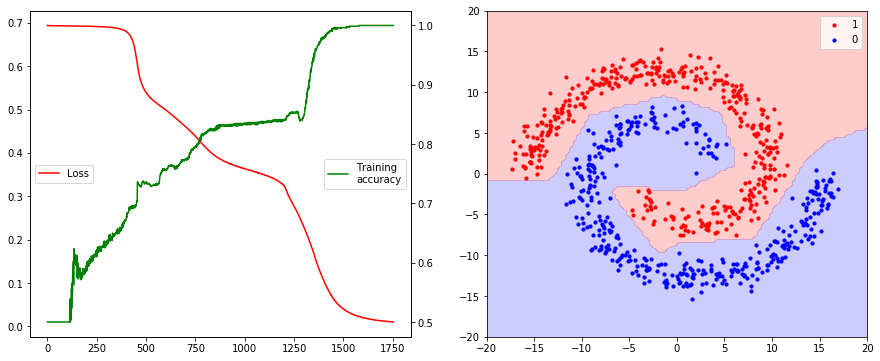

Training accuracy = 100.00%, 
Epochs = 1753


In [10]:
z2 = model2.predict(mesh).reshape(xx.shape)
plot(z2, model2.epochs, model2.training_acc, model2.loss)

#### Third model is with batches of size 100, alpha 0.01 and with momentum (0.8)

In [11]:
model3 = NN(layers, activations, loss_func)
%timeit model3.train(data[:, :-1], data[:, -1][:, None], epochs=5000, alpha=0.01, batchsize=100, momentum=0.8)

3.71 s ± 265 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Converges in around 4s and after 361 epochs, over 10 times faster than model 1

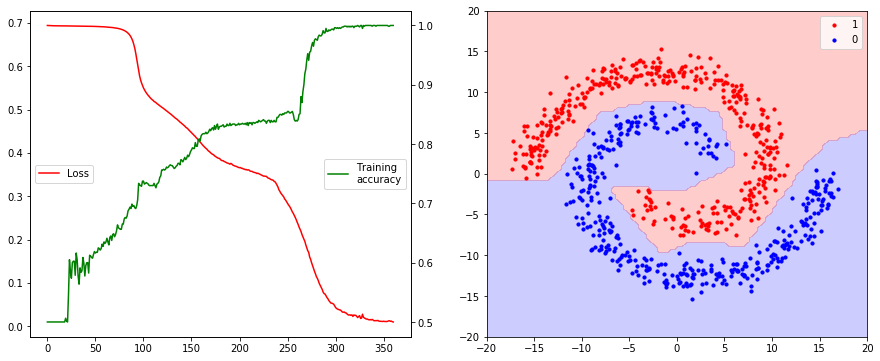

Training accuracy = 100.00%, 
Epochs = 361


In [12]:
z3 = model3.predict(mesh).reshape(xx.shape)
plot(z3, model3.epochs, model3.training_acc, model3.loss)

### Dataset 2
Generating some data to test the class for regression applications

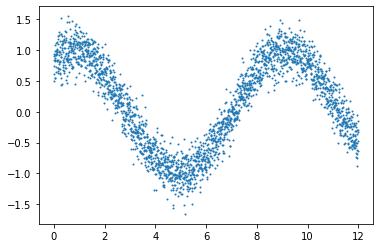

In [13]:
m = 0.75
c = 1
eps = 0.2
x = np.arange(0, 12, 0.005)
y = np.sin(m * x + c) + eps * np.random.randn(len(x))
plt.scatter(x, y, s=1)
plt.show()

#### Changed the activations and loss function to be suitable for regression

In [14]:
layers2 = [1, 8, 32, 8, 1]
activations2 = ['relu', 'relu', 'relu', 'regression']
loss_func2 = 'squared_loss'

In [15]:
regression = NN(layers2, activations2, loss_func2)
regression.train(x[:, None], y[:, None], epochs=100, alpha=0.01, batchsize=100, momentum=0.9)

#### Functions as expected

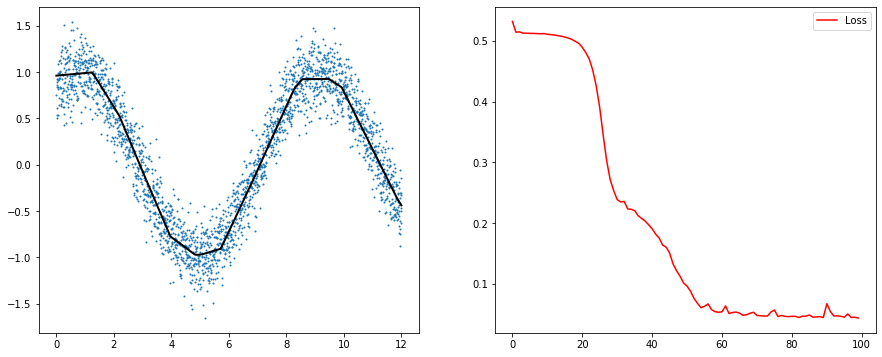

In [16]:
x2 = np.linspace(0, 12, 500)[:, None]
y2 = np.squeeze(regression.predict(x2[:, None]))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(x2, y2, 'k', linewidth=2)
ax[0].scatter(x, y, s=1)
ax[1].plot(range(regression.epochs), np.squeeze(regression.loss), 'r', label='Loss')
plt.legend()
plt.show()